# **Model_Scratch 02** - With data augmentation
Name: `Alberto Pingo` \
Email: `2202145`@my.ipleiria.pt 

Validation dataset: `train5` 

## Directories
This section sets up the directory paths used for training, validation, and test datasets based on the repository structure.

In [1]:
import os

current_dir = os.getcwd()

# TWO FOLDERS UP
data_dir = os.path.abspath(os.path.join(current_dir, os.pardir, os.pardir, 'data'))
test_dir = os.path.join(data_dir, 'test')
train_dir = os.path.join(data_dir, 'train')

train_dirs = []
for i in range(1, 5):
    train_dirs.append(os.path.join(train_dir, 'train' + str(i)))


validation_dir = os.path.join(data_dir, 'train', 'train5')

print(current_dir)
print(data_dir)
print(test_dir)
print(train_dir)
print(validation_dir)

/home/pws/code/IA-image-classification/notebooks/models-S
/home/pws/code/IA-image-classification/data
/home/pws/code/IA-image-classification/data/test
/home/pws/code/IA-image-classification/data/train
/home/pws/code/IA-image-classification/data/train/train5


## Preprocessing
Load the datasets and perform initial preprocessing. Images are resized to 32x32 pixels and batched.

In [2]:

from keras.utils import image_dataset_from_directory
import tensorflow as tf

# Load training datasets from train1 to train4
train_datasets = []
IMG_SIZE = 32
BATCH_SIZE = 64
for i in range(1, 5):
    dataset = image_dataset_from_directory(train_dirs[i-1], image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, label_mode='int')
    train_datasets.append(dataset)
 
train_dataset = train_datasets[0]
for dataset in train_datasets[1:]:
    train_dataset = train_dataset.concatenate(dataset)

validation_dataset = image_dataset_from_directory(validation_dir, image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, label_mode='int')

test_dataset = image_dataset_from_directory(test_dir, image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, label_mode='int')

class_names = validation_dataset.class_names
class_names = [class_name.split('_')[-1] for class_name in class_names]

print(class_names)

2024-06-22 21:13:29.856133: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-22 21:13:29.856173: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-22 21:13:29.862190: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-22 21:13:29.964286: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-22 21:13:31.281108: W tensorflow/compiler/tf2

Found 10000 files belonging to 10 classes.


2024-06-22 21:13:33.348462: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-22 21:13:33.711339: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-22 21:13:33.711491: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Configure the dataset for performance

In [3]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

## **Data Augmentation**
Rendom change of flipping the image horizontally. \
Random chance of moving the image horizontally and vertically [-10%, 10%].

Tried with a more complex approach to data augmentation, but the results were worse because of the small size of the images.

In [4]:
from keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomTranslation(0.1, 0.1, fill_mode='nearest'),
])

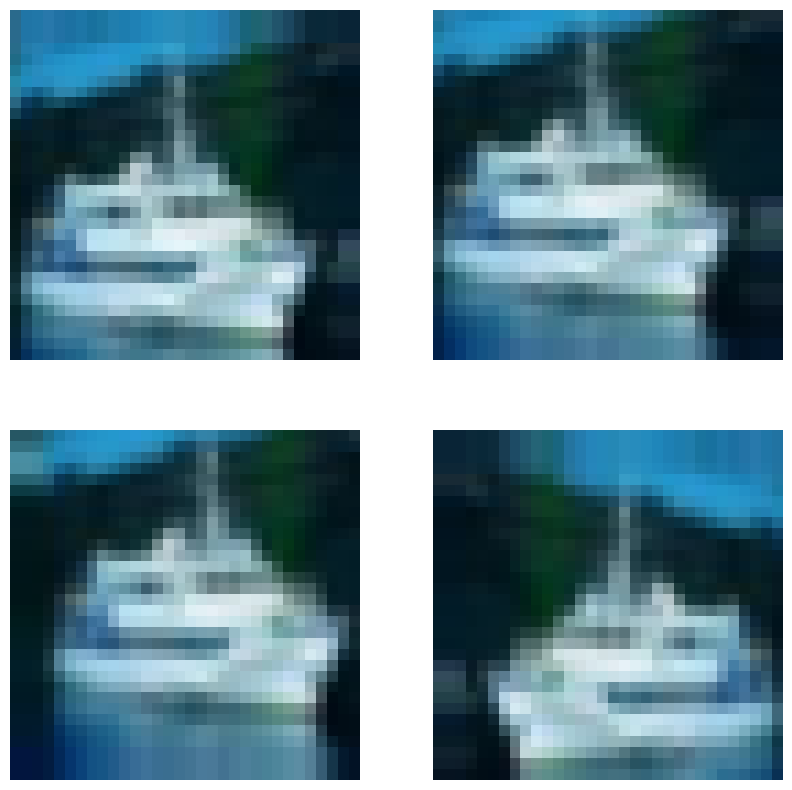

In [5]:
import matplotlib.pyplot as plt
import numpy as np

#Plot some Augmented images
for images, labels in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

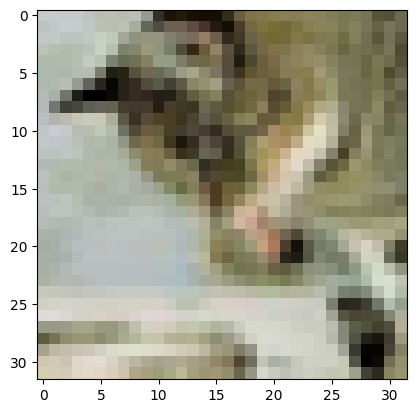

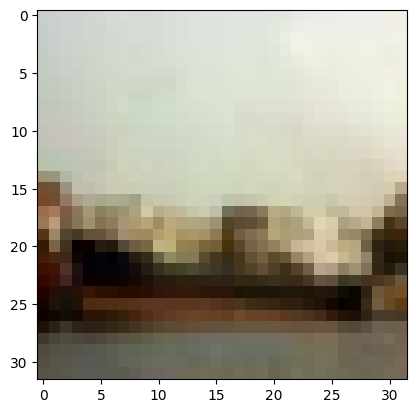

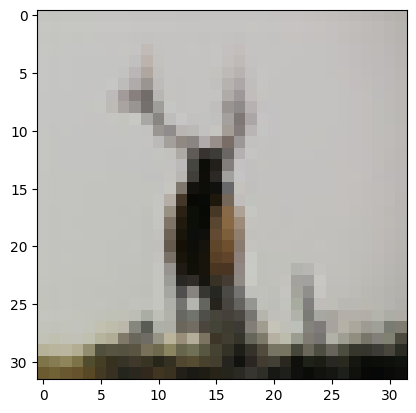

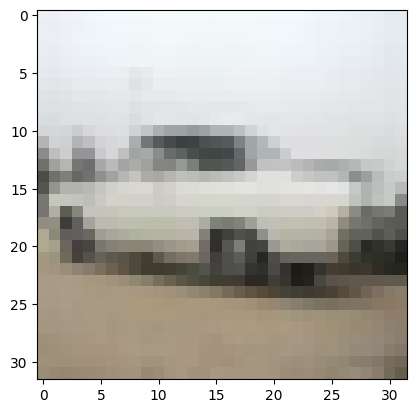

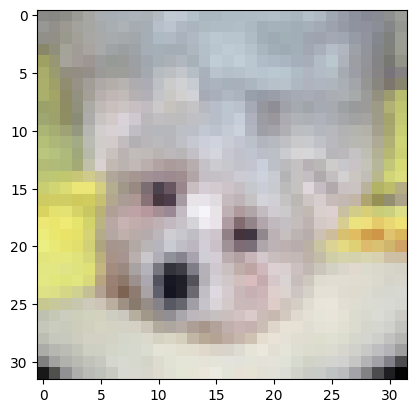

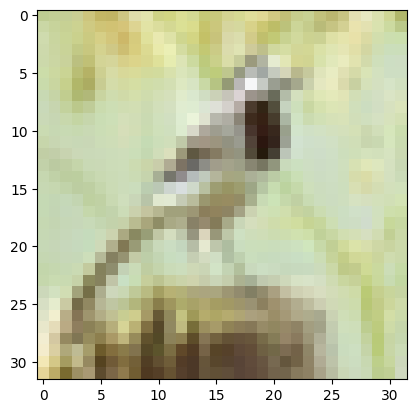

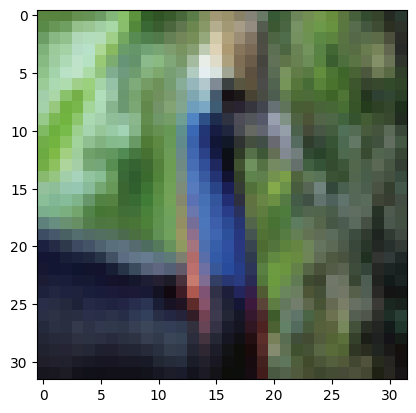

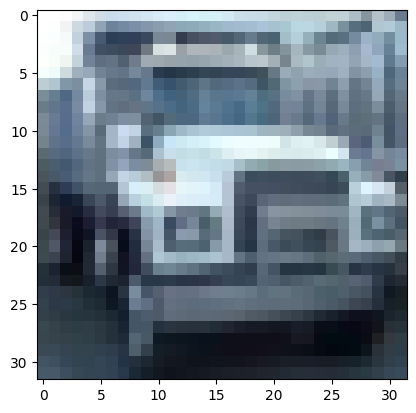

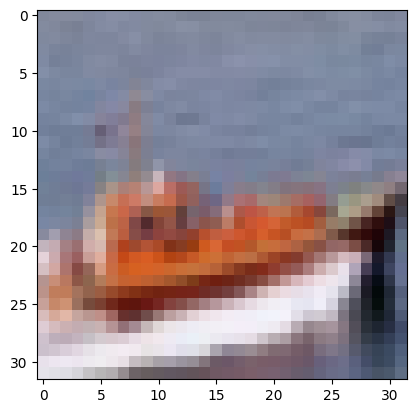

In [6]:
import matplotlib.pyplot as plt

for data, _ in train_dataset.take(1):
    for i in range(9):
        plt.imshow(data[i].numpy().astype('uint8'))
        plt.show()
    break

# **MODEL ARCHITECTURE**

## Build a Convolutional Neural Network (CNN) model.

**Architecture:**

Input -> Conv2D - BN -> MaxPooling2D -> Conv2D - BN-> MaxPooling2D -> Conv2D - BN-> MaxPooling2D -> Flatten -> Dense - BN -> Dropout -> Dense - BN -> Dropout -> Output


1. **Input Layer**
   - The input layer expects images of size 32x32 pixels with 3 color channels (RGB).
   - No data augmentation is applied to the input images.
   - The Rescaling layer, rescales the pixel values from the range [0, 255] to [0, 1].

3. **Convolutional Layers**
   - The model consists of 3 convolutional layers with 32, 64 and 128 filters respectively.
   - Use padding='same' to preserve the spatial dimensions of the feature maps.
   
4. **Max Pooling Layers**
   - Max pooling layers are used after each convolutional layer to reduce the spatial dimensions of the feature maps.
   - A pooling size of 2x2 is used.

5. **Fully connected layers** 
   - A dense layer with 512 units and ReLU activation function.
   - A dense layer with 256 units and ReLU activation function.

6. **Output Layer**
   - The output layer consists of 10 units (one for each class) with a softmax activation function.
   - The softmax function outputs the probability distribution over the classes.

**Overfitting measures**
   - Dropout layers are used after each Convolutional and Dense layer to prevent overfitting.

**Batch Normalization**
   - Batch normalization is used after each Convolutional layer to normalize the activations of the previous layer at each batch.
   - This helps to stabilize and speed up the training process.

In [7]:
from tensorflow import keras
from keras import layers, regularizers

inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

x = data_augmentation(inputs)

x = layers.Rescaling(1./255)(x)

## First Convolutional Block
x = layers.Conv2D(filters=32, kernel_size=3, padding='same', activation="relu")(x)
x = layers.BatchNormalization()(x) # Standardize the inputs to the next layer, stabilizes and speeds up training
x = layers.MaxPooling2D(pool_size=2)(x)

# Second Convolutional Block

x = layers.Conv2D(filters=64, kernel_size=3, padding='same', activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)

# Third Convolutional Block
x = layers.Conv2D(filters=128, kernel_size=3, padding='same', activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)


x = layers.Flatten()(x)

x = layers.Dense(512, activation="relu")(x) # Fully connected layer
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(10, activation="softmax")(x)  # Softmax for multi-class classification

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 32, 32, 3)         0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                          

## Compile Model

**Loss function:** \
Use the *Sparse Categorical Crossentropy* loss function because it is a `multi-class classification` problem.

**Optimizer: RMSprop** \
Exploring the *RMSprop* optimizer.

In [8]:
from keras import optimizers

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizers.RMSprop(learning_rate=0.001),
    metrics=['acc'])

## Train Model
Train the model with Early stopping, Model checkpoint, and Learning rate reduction callbacks.

In [9]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_acc', 
    patience=3, 
    verbose=1, 
    factor=0.5, 
    min_lr=1e-5)

early_stop = EarlyStopping(monitor='val_acc', 
                           patience=6,
                           restore_best_weights=True)
model_checkpoint = ModelCheckpoint('models/S02/checkpoints/S02-DA-cp.h5', save_best_only=True)

history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=[early_stop, model_checkpoint, learning_rate_reduction])

Epoch 1/100


2024-06-22 21:13:42.893017: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-06-22 21:13:44.811580: I external/local_xla/xla/service/service.cc:168] XLA service 0x7c7cec577f40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-22 21:13:44.811657: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
2024-06-22 21:13:44.817436: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1719087224.860796  135320 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


628/628 [==============================] - 11s 11ms/step - loss: 1.6528 - acc: 0.4524 - val_loss: 1.1419 - val_acc: 0.5954 - lr: 0.0010
Epoch 2/100
 15/628 [..............................] - ETA: 4s - loss: 1.1153 - acc: 0.5958

/home/pws/miniconda3/envs/tensorflow/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


628/628 [==============================] - 5s 9ms/step - loss: 1.1086 - acc: 0.6110 - val_loss: 1.0601 - val_acc: 0.6335 - lr: 0.0010
Epoch 3/100
628/628 [==============================] - 6s 9ms/step - loss: 0.9522 - acc: 0.6705 - val_loss: 0.9207 - val_acc: 0.6807 - lr: 0.0010
Epoch 4/100
628/628 [==============================] - 6s 9ms/step - loss: 0.8459 - acc: 0.7068 - val_loss: 0.7693 - val_acc: 0.7300 - lr: 0.0010
Epoch 5/100
628/628 [==============================] - 6s 9ms/step - loss: 0.7720 - acc: 0.7316 - val_loss: 0.7561 - val_acc: 0.7390 - lr: 0.0010
Epoch 6/100
628/628 [==============================] - 5s 9ms/step - loss: 0.7269 - acc: 0.7481 - val_loss: 0.7567 - val_acc: 0.7417 - lr: 0.0010
Epoch 7/100
628/628 [==============================] - 6s 9ms/step - loss: 0.6827 - acc: 0.7661 - val_loss: 0.9545 - val_acc: 0.6982 - lr: 0.0010
Epoch 8/100
628/628 [==============================] - 5s 9ms/step - loss: 0.6442 - acc: 0.7783 - val_loss: 0.7213 - val_acc: 0.7539 - l

## Save Model

In [10]:
keras.models.save_model(model, 'models/S02/S02-DA-model.h5')

/tmp/ipykernel_135234/967095280.py:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  keras.models.save_model(model, 'models/S02/S02-DA-model.h5')


## Load Model

In [11]:
keras.models.load_model('models/S02/S02-DA-model.h5')

# **EVALUATION**

## Evaluate the model on the validation dataset.

In [12]:
val_loss, val_acc = model.evaluate(validation_dataset)
print('val_acc:', val_acc)

157/157 [==============================] - 0s 3ms/step - loss: 0.5245 - acc: 0.8490
val_acc: 0.8489999771118164


## Training and Validation Curves
Plot the training and validation accuracy and loss curves.

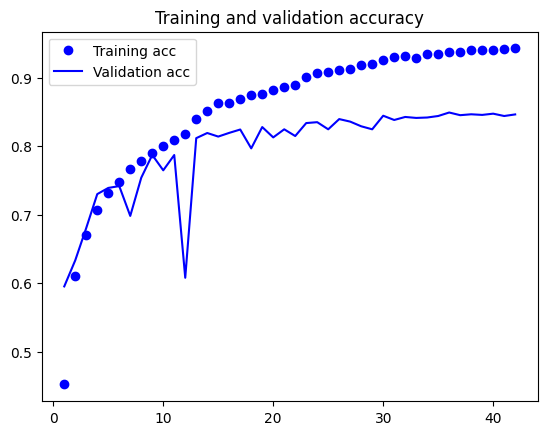

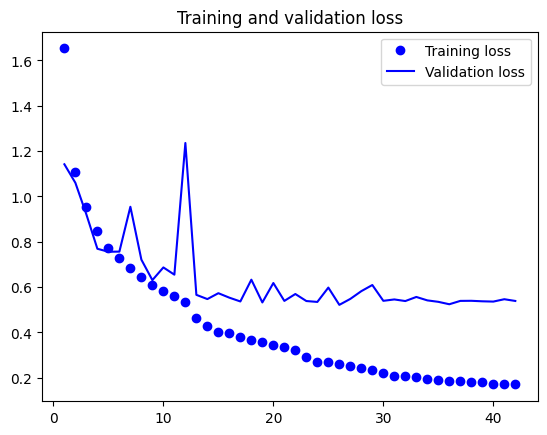

In [13]:

import matplotlib.pyplot as plt

# Extract the history from the training process
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plot the training and validation accuracy
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

# Plot the training and validation loss
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Confusion Matrix

1/1 [==============================] - 0s 109ms/step


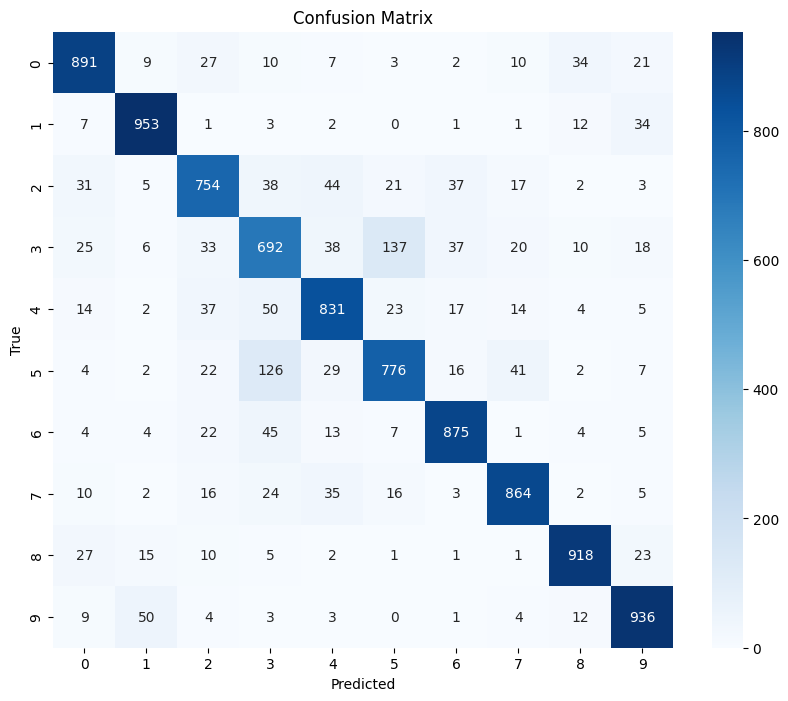

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_true = []
y_pred = []

for features, labels in validation_dataset:
    predictions = model.predict(features)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [15]:
# Display the confusion matrix
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[891   9  27  10   7   3   2  10  34  21]
 [  7 953   1   3   2   0   1   1  12  34]
 [ 31   5 754  38  44  21  37  17   2   3]
 [ 25   6  33 692  38 137  37  20  10  18]
 [ 14   2  37  50 831  23  17  14   4   5]
 [  4   2  22 126  29 776  16  41   2   7]
 [  4   4  22  45  13   7 875   1   4   5]
 [ 10   2  16  24  35  16   3 864   2   5]
 [ 27  15  10   5   2   1   1   1 918  23]
 [  9  50   4   3   3   0   1   4  12 936]]


In [16]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

              precision    recall  f1-score   support

    airplane       0.87      0.88      0.88      1014
  automobile       0.91      0.94      0.92      1014
        bird       0.81      0.79      0.80       952
         cat       0.69      0.68      0.69      1016
        deer       0.83      0.83      0.83       997
         dog       0.79      0.76      0.77      1025
        frog       0.88      0.89      0.89       980
       horse       0.89      0.88      0.89       977
        ship       0.92      0.92      0.92      1003
       truck       0.89      0.92      0.90      1022

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



## Predictions

Predict and visualize the results for a sample image.

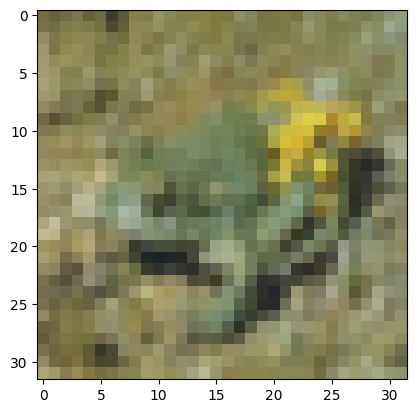

(1, 32, 32, 3)
1/1 [==============================] - 0s 209ms/step
Result:  [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


In [17]:
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing import image

# Load an image
img = tf.keras.preprocessing.image.load_img(train_dirs[0] + '/006_frog/alytes_obstetricans_s_000179.png', target_size=(32, 32), interpolation='bilinear')
# img = tf.keras.preprocessing.image.load_img(train_dirs[0] + '/000_airplane/airbus_s_000012.png', target_size=(32, 32), interpolation='bilinear')

# Preprocess the image
img_array = image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

plt.imshow(img)
plt.show()

print(img_array.shape)
result = model.predict(img_array)
print("Result: ", result.round())